Validation Accuracy: 0.568
Validation Confusion Matrix (Numeric):
[[154  48  55]
 [ 88 332 119]
 [166 282 509]]
Validation Classification Report:
              precision    recall  f1-score   support

 Blockbuster       0.38      0.60      0.46       257
        Flop       0.50      0.62      0.55       539
     Success       0.75      0.53      0.62       957

    accuracy                           0.57      1753
   macro avg       0.54      0.58      0.55      1753
weighted avg       0.62      0.57      0.58      1753

Test Accuracy: 0.558
Test Confusion Matrix (Numeric):
[[163  64  66]
 [ 71 329 122]
 [193 258 487]]
Test Classification Report:
              precision    recall  f1-score   support

 Blockbuster       0.38      0.56      0.45       293
        Flop       0.51      0.63      0.56       522
     Success       0.72      0.52      0.60       938

    accuracy                           0.56      1753
   macro avg       0.54      0.57      0.54      1753
weighted avg       

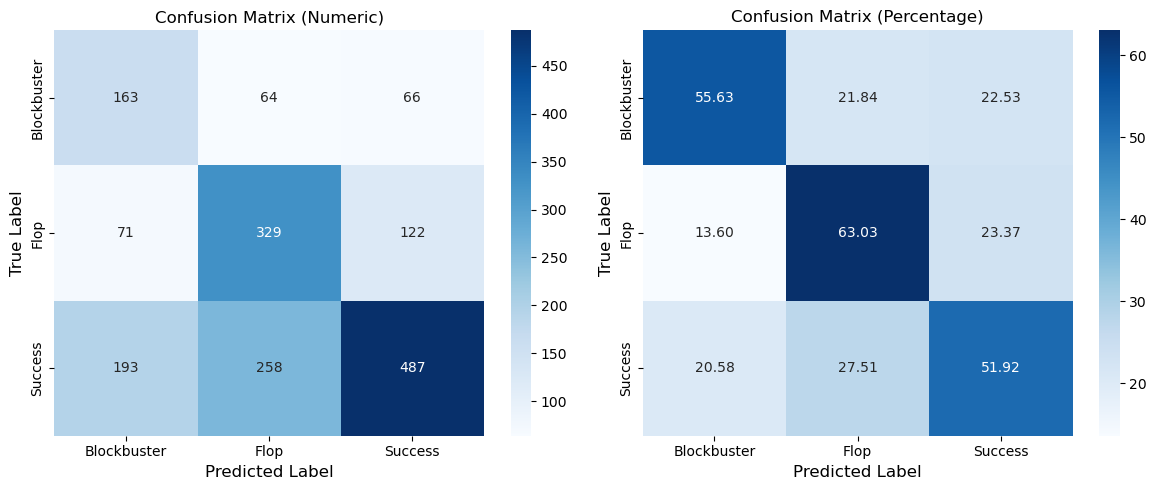

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ------------------------------------------------------------------------
# 1. Load data
# ------------------------------------------------------------------------
train_data = pd.read_csv('train_data.csv')
validation_data = pd.read_csv('validation_data.csv')
test_data = pd.read_csv('test_data.csv')

# ------------------------------------------------------------------------
# 2. Define features and target
# ------------------------------------------------------------------------
features = [
    'runtime', 'budget', 'genres',
    'production_companies', 'production_countries',
    'spoken_languages', 'director1', 'actor1Name'
]
target = 'success_level'

X_train = train_data[features]
y_train = train_data[target]
X_val = validation_data[features]
y_val = validation_data[target]
X_test = test_data[features]
y_test = test_data[target]

# ------------------------------------------------------------------------
# 3. Preprocessing pipelines
# ------------------------------------------------------------------------
numeric_features = ['runtime', 'budget']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = [
    'genres', 'production_companies',
    'production_countries', 'spoken_languages',
    'director1', 'actor1Name'
]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ------------------------------------------------------------------------
# 4. Model pipeline (SVD + GradientBoosting + SMOTE)
# ------------------------------------------------------------------------
svd = TruncatedSVD(n_components=100, random_state=42)
classifier = GradientBoostingClassifier(random_state=42)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('svd', svd),
    ('classifier', classifier)
])

# ------------------------------------------------------------------------
# 5. Train model
# ------------------------------------------------------------------------
pipeline.fit(X_train, y_train)

# ------------------------------------------------------------------------
# 6. Evaluate on validation data
# ------------------------------------------------------------------------
y_val_pred = pipeline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_acc:.3f}')
print("Validation Confusion Matrix (Numeric):")
print(confusion_matrix(y_val, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# ------------------------------------------------------------------------
# 7. Evaluate on test data (final)
# ------------------------------------------------------------------------
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_acc:.3f}')

# Define the class order (ensure this order matches your data)
classes = ['Blockbuster', 'Flop', 'Success']

# Compute the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred, labels=classes)
print("Test Confusion Matrix (Numeric):")
print(cm)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, labels=classes))

# ------------------------------------------------------------------------
# 8. Plot confusion matrix heatmaps side by side: Numeric and Percentage
# ------------------------------------------------------------------------
# Calculate percentage matrix (row-normalized)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Numeric confusion matrix heatmap (blue color map)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title("Confusion Matrix (Numeric)")
axes[0].set_xlabel("Predicted Label", fontsize=12)
axes[0].set_ylabel("True Label", fontsize=12)

# Percentage confusion matrix heatmap (pink color map)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title("Confusion Matrix (Percentage)")
axes[1].set_xlabel("Predicted Label", fontsize=12)
axes[1].set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()